In [1]:
!git clone https://github.com/popoboby/Quantum_Circuit_transformation.git

Cloning into 'Quantum_Circuit_transformation'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 89 (delta 37), reused 75 (delta 23), pack-reused 0
Receiving objects: 100% (89/89), 888.62 KiB | 842.00 KiB/s, done.
Resolving deltas: 100% (37/37), done.


In [1]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer,circuit_drawer
from matplotlib import pyplot as plt
from qiskit.dagcircuit import DAGOpNode
from collections import defaultdict
from qiskit.circuit.quantumregister import Qubit
from qiskit import QuantumRegister
from qiskit.transpiler import CouplingMap, Layout
from copy import copy
from qiskit.circuit.library.standard_gates import SwapGate, CXGate
import networkx as nx
import numpy as np

num_q = 5

# edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(1,6),(2,7),(3,8),(4,9),(1,7),(2,6),(3,9),(4,8),(5,6),(6,7),(7,8),(8,9),(5,10),(6,11),(7,12),(8,13),(9,14),(5,11),(6,10),(7,13),(8,12),(10,11),(11,12),(12,13),(13,14),(10,15),(11,16),(12,17),(13,18),(14,19),(11,17),(12,16),(13,19),(14,18),(15,16),(16,17),(17,18),(18,19)]

# coupling_map = CouplingMap(couplinglist=edges)
coupling_map = CouplingMap(couplinglist=[(0,1),(1,2),(2,3),(3,4)])
mapped_cir = QuantumCircuit(num_q)
canonical_register = QuantumRegister(num_q, "q")

In [3]:
cd Quantum_Circuit_transformation

/home/sangam/sem6/RL/Quantum_Circuit_transformation


In [3]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer,circuit_drawer
from matplotlib import pyplot as plt
from qiskit.dagcircuit import DAGOpNode
from collections import defaultdict
from qiskit.circuit.quantumregister import Qubit
from qiskit import QuantumRegister
from qiskit.transpiler import CouplingMap, Layout
from copy import copy
from qiskit.circuit.library.standard_gates import SwapGate, CXGate
import networkx as nx
import numpy as np

num_q = 5

# edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(1,6),(2,7),(3,8),(4,9),(1,7),(2,6),(3,9),(4,8),(5,6),(6,7),(7,8),(8,9),(5,10),(6,11),(7,12),(8,13),(9,14),(5,11),(6,10),(7,13),(8,12),(10,11),(11,12),(12,13),(13,14),(10,15),(11,16),(12,17),(13,18),(14,19),(11,17),(12,16),(13,19),(14,18),(15,16),(16,17),(17,18),(18,19)]

# coupling_map = CouplingMap(couplinglist=edges)
coupling_map = CouplingMap(couplinglist=[(0,1),(1,2),(2,3),(3,4)])
mapped_cir = QuantumCircuit(num_q)
canonical_register = QuantumRegister(num_q, "q")
def _successors(node, dag):
    print("I am in successor", node)
#     print(dag.edges(node))
    for _, successor, edge_data in dag.edges(node):
        print(_,successor,edge_data)
        if type(successor) != DAGOpNode:
            continue
        if isinstance(edge_data, Qubit):
            yield successor

def _is_resolved(applied_predecessors, node):
    return applied_predecessors[node] == len(node.qargs)

def _transform_gate_for_layout(op_node, layout, device_qreg): # 未知
    """Return node implementing a virtual op on given layout."""
    mapped_op_node = copy(op_node)
    premap_qargs = op_node.qargs
    mapped_qargs = map(lambda x: device_qreg[layout[x]], premap_qargs)
    mapped_op_node.qargs = list(mapped_qargs)
    return mapped_op_node

def _apply_gate( mapped_cir, node, current_layout, canonical_register): # 应用门
    new_node = _transform_gate_for_layout(node, current_layout, canonical_register)
    mapped_cir.append(new_node.op, new_node.qargs, new_node.cargs)


def _obtain_swaps(coupling_map, front_layer, current_layout, _bit_indices): # 得到当前能够执行的交换操作
    # Q = QuantumRegister(coupling_map.size(), "q")
    print("obtain swap", front_layer)
    candidate_swaps = set() # 一个集合变量
    for node in front_layer: # 遍历最前层的节点
        for virtual in node.qargs: # 节点的门操纵
            physical = current_layout[virtual] # 物理比特 （关注一下）
            for neighbor in coupling_map.neighbors(physical): # 只有相邻的物理比特才可以执行
                virtual_neighbor = current_layout[neighbor]
                print(virtual,virtual_neighbor)
                swap = sorted([virtual, virtual_neighbor], key=lambda q: _bit_indices[q])
                print(swap)
                candidate_swaps.add(tuple(swap))
    return candidate_swaps # 返回候选交换门

# path = 'E:/files/quant/code/quantum/qasm_circuits/3_17_14.qasm'
# path = '/content/Quantum_Circuit_transformation/3_17_14.qasm'
# path ='/home/sangam/sem6/RL/Quantum_Circuit_transformation/3_17_14.qasm'
path ='/home/sangam/sem6/RL/Quantum_Circuit_transformation/cir6.qasm'
def get_scores(coupling_map, front_layer, current_layout, trial_layout, score_layer, applied_predecessors, dag, EXTENDED_SET_SIZE):
    cost = 0.0

    involved_nodes = front_layer.copy()
    for node in front_layer:
        v0, v1 = node.qargs
        cost += (coupling_map.distance(current_layout[v0], current_layout[v1]) - coupling_map.distance(trial_layout[v0], trial_layout[v1]))
        print(cost)
    if cost < 0: # 当前操作无法使第一层节点的距离之差之和 > 0
        # 不再执行后续操作，直接返回值
        return cost

    cost = 0.0
    # 如果该交换可以使得第一层之和值大于0，则继续后面五层的操作
    score_add = 0.0

    added_swaps = 1
    isPos = True
    decay = 1
    i = 0
    for layer_i in range(score_layer): # 往后看score_layer层
        i_max = len(involved_nodes)
        flag = False
        while i <= i_max - 1:
            node = involved_nodes[i]
            i += 1
            if len(node.qargs) == 1:
                for successor in _successors(node, dag):
                    if not successor in involved_nodes:
                        involved_nodes.append(successor)
                continue
            flag = True
            v0, v1 = node.qargs
            score_add = coupling_map.distance(current_layout[v0], current_layout[v1]) - coupling_map.distance(trial_layout[v0], trial_layout[v1])
            print("score_add", score_add)
            if score_add > 0:
                isPos = True

            if score_add < 0 and isPos:
                added_swaps += 1
                score_add = 0
                isPos = False

            if isPos == False and score_add < 0:
                score_add = 0

            cost += score_add * decay
            for successor in _successors(node, dag):
                if not successor in involved_nodes:
                    involved_nodes.append(successor)
        if flag:
            decay *= 0.8
        else:
            layer_i -= 1

    return cost / added_swaps


draw_paint = 1
draw_result = 1


def get_execute_gates(self, front_layer, initial_layout, dag, coupling_map, mapped_cir):
    trial_layer = front_layer

    execute_gates_list = []
    for node in front_layer:
        if node.name == 'cx':
            v0, v1 = node.qargs
            if coupling_map.graph.has_edge(initial_layout[v0], initial_layout[v1]):
                execute_gates_list.append(node)

        else:
            execute_gates_list.append(node)


    if execute_gates_list:

        for node in execute_gates_list:
            _apply_gate(mapped_cir, node, initial_layout, canonical_register)

            front_layer.remove(node)

            for successor in _successors(node, dag):

                applied_predecessors[successor] += 1






if __name__ == '__main__':
    num_search_steps = 0

    circuit = QuantumCircuit.from_qasm_file(path)
    dag = circuit_to_dag(circuit)
    
    if draw_paint:
      print(circuit)
    front_layer = dag.front_layer()
#     print("I am here")
#     print(front_layer)
    initial_mapping = [i for i in range(len(dag.qubits))]

    applied_predecessors = defaultdict(int)
    print(dag.input_map.items())
    for _, input_node in dag.input_map.items():
        print(_,input_node)
        for successor in _successors(input_node, dag):
#             print(successor)
            applied_predecessors[successor] += 1


    seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng = np.random.default_rng(seed)
    
    # initial_mapping = rng.permutation(initial_mapping)
    initial_layout = Layout({q: dag.qubits[i] for i, q in enumerate(initial_mapping)})
    print(initial_layout)
    canonical_register = QuantumRegister(num_q, 'q')
    _bit_indices = {bit: idx for idx, bit in enumerate(canonical_register)}
    print(_bit_indices)
    while front_layer:
        print("I am here")
        for node in front_layer:
            pass

        execute_gate_list = []

        for node in front_layer:
            print(node)
            if node.name == 'cx':
                v0, v1 = node.qargs
                if coupling_map.graph.has_edge(initial_layout[v0], initial_layout[v1]):
                    execute_gate_list.append(node)
            else:
                execute_gate_list.append(node)


        if execute_gate_list:
            for node in execute_gate_list:
                _apply_gate(mapped_cir, node, initial_layout, canonical_register)

                front_layer.remove(node)
                for successor in _successors(node, dag):
                    applied_predecessors[successor] += 1

                    if _is_resolved(applied_predecessors, successor):
                        print("yes")
                        front_layer.append(successor)
            continue

        ''' 以上全部属于 '''

        swap_candidates = _obtain_swaps(coupling_map, front_layer, initial_layout, _bit_indices)
        print("okay",swap_candidates)
        swap_scores = dict.fromkeys(swap_candidates, 0)
        print("swap scores",swap_scores)

        score_layer = 10

        for swap_qubits in swap_scores:
            print("inside 4", *swap_qubits)
            trial_layout = initial_layout.copy()
            trial_layout.swap(*swap_qubits)
            print(initial_layout)
            print(trial_layout)
            scores = get_scores(coupling_map, front_layer, initial_layout, trial_layout, score_layer, applied_predecessors, dag, 3)
            print("score",scores)
            swap_scores[swap_qubits] = scores

        max_score = max(swap_scores.values())
        best_swaps = [k for k, v in swap_scores.items() if v == max_score]
        best_swap = rng.choice(best_swaps)
        swap_node = DAGOpNode(op=SwapGate(), qargs=best_swap)
        _apply_gate(mapped_cir, swap_node, initial_layout, canonical_register)
        initial_layout.swap(*best_swap)
        num_search_steps += 1
        
        
        
    
    if draw_result:
#         print(mn)
        print(mapped_cir)


          ┌───┐┌───┐          ┌───┐
q_0: ──■──┤ H ├┤ T ├───────■──┤ X ├
       │  ├───┤├───┤┌───┐  │  └─┬─┘
q_1: ──┼──┤ X ├┤ T ├┤ X ├──┼────■──
     ┌─┴─┐└─┬─┘├───┤└─┬─┘┌─┴─┐     
q_2: ┤ X ├──■──┤ T ├──■──┤ X ├─────
     └───┘     └───┘     └───┘     
c: 3/══════════════════════════════
                                   
odict_items([(Qubit(QuantumRegister(3, 'q'), 0), DAGInNode(wire=Qubit(QuantumRegister(3, 'q'), 0))), (Qubit(QuantumRegister(3, 'q'), 1), DAGInNode(wire=Qubit(QuantumRegister(3, 'q'), 1))), (Qubit(QuantumRegister(3, 'q'), 2), DAGInNode(wire=Qubit(QuantumRegister(3, 'q'), 2))), (Clbit(ClassicalRegister(3, 'c'), 0), DAGInNode(wire=Clbit(ClassicalRegister(3, 'c'), 0))), (Clbit(ClassicalRegister(3, 'c'), 1), DAGInNode(wire=Clbit(ClassicalRegister(3, 'c'), 1))), (Clbit(ClassicalRegister(3, 'c'), 2), DAGInNode(wire=Clbit(ClassicalRegister(3, 'c'), 2)))])
Qubit(QuantumRegister(3, 'q'), 0) 139015973457216
I am in successor 139015973457216
139015973457216 139015981042160 Qubit(

KeyError: Qubit(QuantumRegister(3, 'q'), 0)

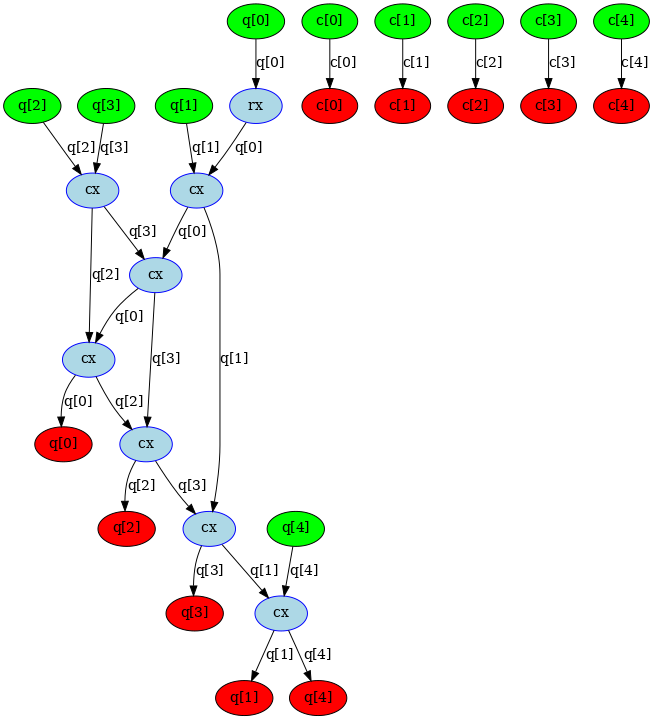

In [48]:
dag_drawer(dag)